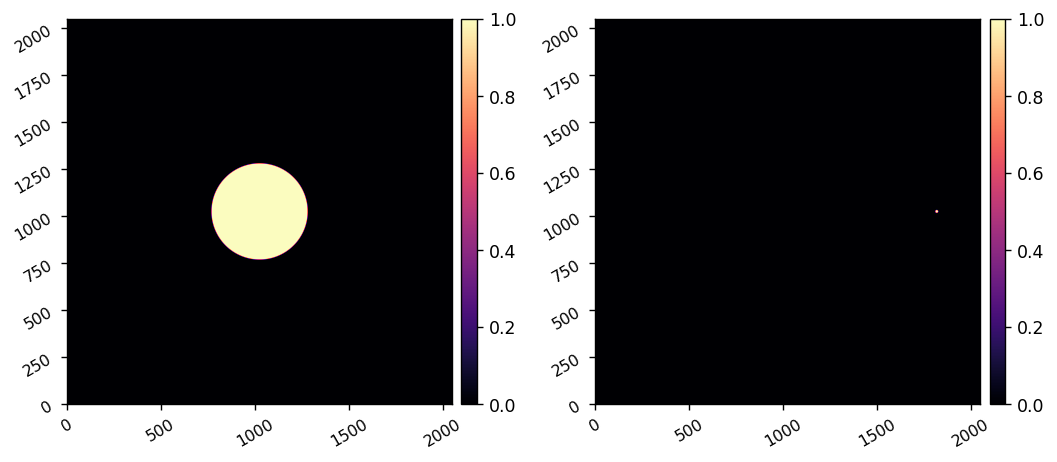

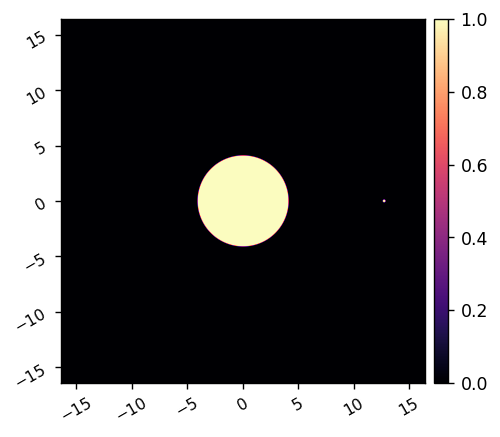

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from importlib import reload

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import scoobpsf
from scoobpsf.math_module import xp, _scipy
from scoobpsf.imshows import *
from scoobpsf import scoob

import lina

pupil_diam = 6.75*u.mm 
det_rotation = 0 #  degrees of rotation of the detector relative to the optical axis

# The flattest wavefront obtained for the system in the lab by
# performing phase diversity
dm_flat = fits.getdata(scoob.module_path/'scoob_dm_flat.fits')

wavelength_c = 632.8e-9*u.m # central wavelength
npix = 512
oversample = 8

vortex = scoobpsf.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)

lyot_diam = 8.2*u.mm
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2.0,)
scc_pinhole = poppy.CircularAperture(name='SCC Pinhole', radius=0.03*lyot_diam/2, shift_x=1.55*lyot_diam)
wf = poppy.FresnelWavefront(beam_radius=lyot_diam/2, npix=512, oversample=4)
lyot_ap = lyot_stop.get_transmission(wf)
scc_ap = scc_pinhole.get_transmission(wf)

imshow2(lyot_ap, scc_ap)
scc_lyot_stop = poppy.ArrayOpticalElement(transmission=lyot_ap+scc_ap, pixelscale=wf.pixelscale, name='Lyot/SCC Mask')
imshow1(scc_lyot_stop.amplitude, pxscl=scc_lyot_stop.pixelscale.to(u.mm/u.pix))

In [8]:
1.55*lyot_diam

<Quantity 13.02 mm>

Model using synthetic OPD data
Using default Gaussian influence function.
Using reflection when computing OPD.


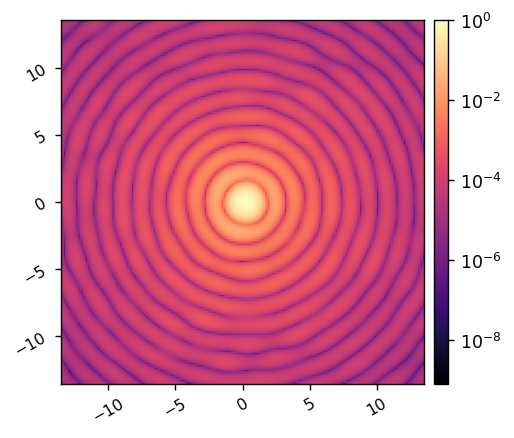

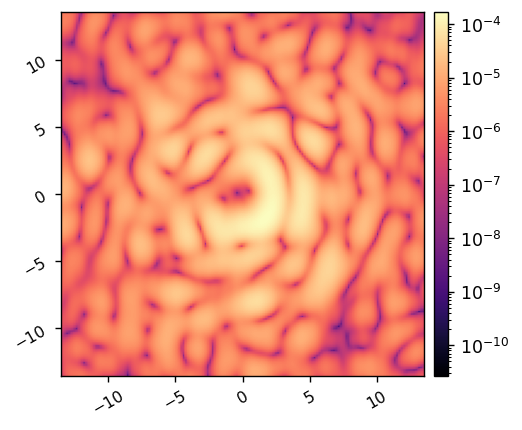

In [11]:
reload(scoob)
model = scoob.SCOOBM(npix=npix, 
                      oversample=oversample, 
                     npsf=150,
                    #  psf_pixelscale_lamD=1/4, 
                      wavelength=wavelength_c, 
                      pupil_diam=pupil_diam,
                      det_rotation=det_rotation, 
                      use_synthetic_opds=True,
#                       dm_ref=dm_flat,
                     )

im0 = model.snap()
model.Imax_ref = im0.max()

ref_unocc_im = model.snap(plot=True)

model.FPM = vortex
model.LYOT = scc_lyot_stop

ref_im = model.snap(plot=True)

In [95]:
model.psf_pixelscale, model.psf_pixelscale_lamD

(<Quantity 3.76 um / pix>, 0.18051670532333897)

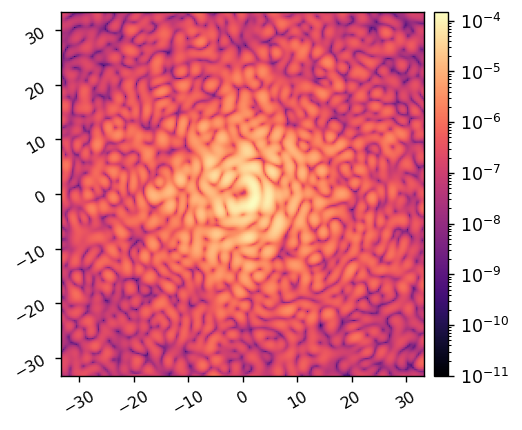

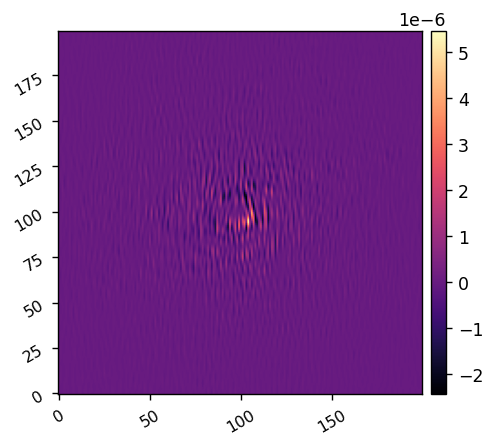

In [77]:
# just checking the fringes

model.FPM = vortex
model.LYOT = lyot_stop

ref_im_2 = model.snap(plot=True, vmin=1e-11)
imshow1(ref_im-ref_im_2)

In [113]:
150/128*8

9.375

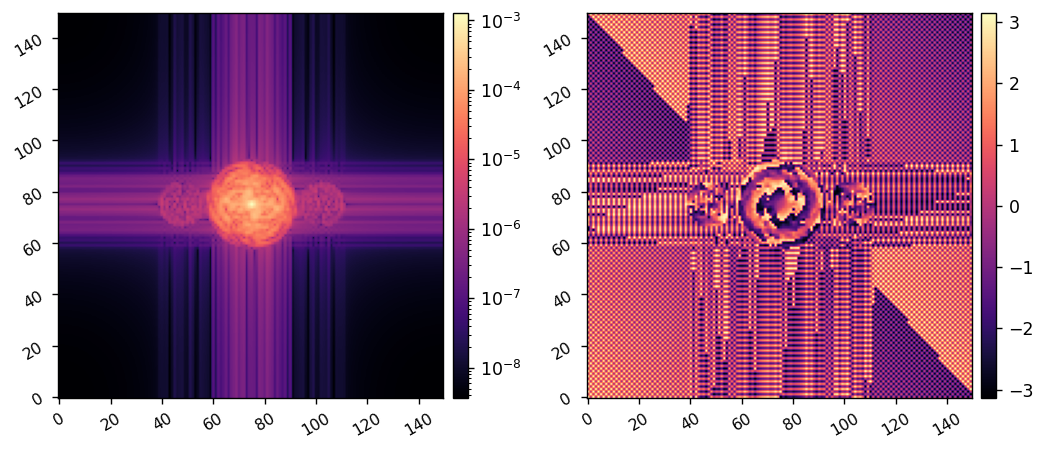

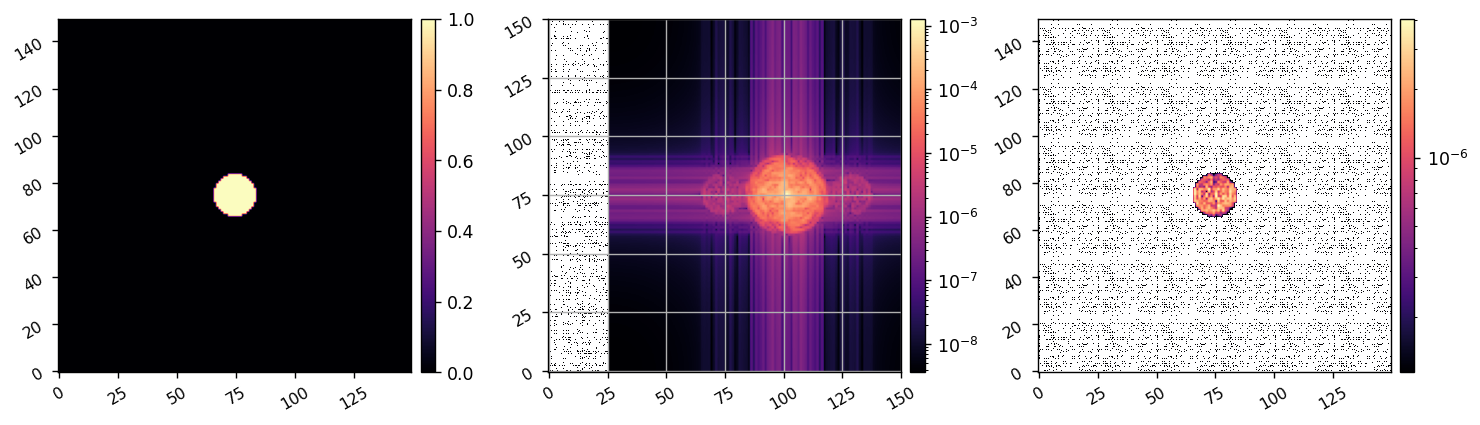

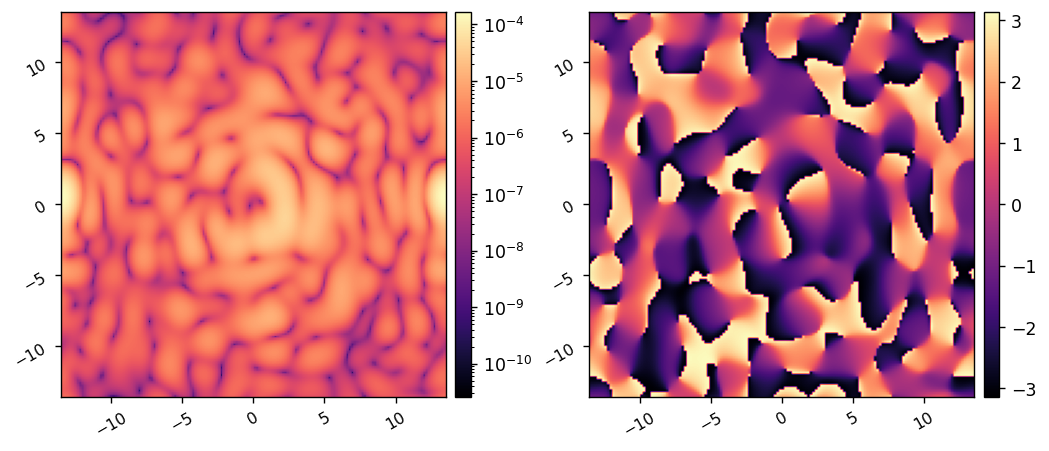

In [18]:
reload(lina.scc)
# E_est = lina.scc.estimate_coherent(model, r_npix=22, shift=(0,65), 
#                                 #    dark_mask=control_mask, 
#                                    plot=True)
E_est = lina.scc.estimate_coherent(model, r_npix=9, shift=(0,26), 
                                #    dark_mask=control_mask, 
                                   plot=True)

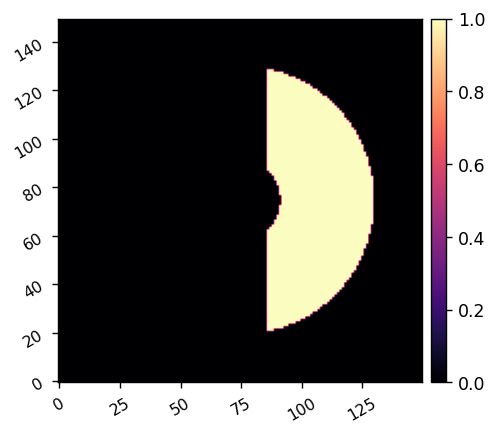

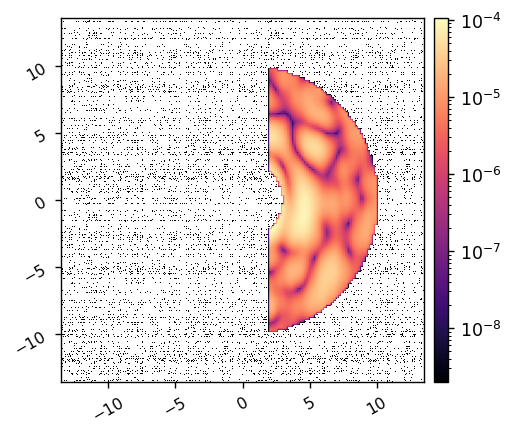

In [118]:
reload(lina.utils)
iwa = 3
owa = 10

control_mask = lina.utils.create_annular_focal_plane_mask(model, iwa, owa, edge=2, shift=(0,0), rotation=0, plot=True)
imshow1(ref_im*control_mask, lognorm=True, pxscl=model.psf_pixelscale_lamD)

In [63]:
scc_fun = lina.scc.estimate_coherent
scc_params = {
    'r_npix':12, 
    'shift':(0,35)
}

In [52]:
model.dm_mask[0,0]

array(False)

In [56]:
reload(lina.efc)

model.reset_dm()
# calib_modes = lina.utils.create_all_poke_modes(model.dm_mask)
calib_modes = lina.utils.create_hadamard_modes(model.dm_mask)
jac = lina.efc.calibrate(model, xp.array(calib_modes), 1e-9, control_mask,
                         scc_fun, scc_params,
                         )

952
Calculating Jacobian: 
	Calculated response for mode 1024/1024. Elapsed time=1157.806 sec.
Jacobian built in 1157.806 sec


In [57]:
lina.utils.save_fits('jac_scc_hadamard.fits', jac)

Saved data to:  jac_scc_hadamard.fits


In [5]:
from astropy.io import fits
jac = xp.array(fits.getdata('jac.fits'))

In [44]:
responses.shape, poke_modes.shape

((1828, 952), (952, 1156))

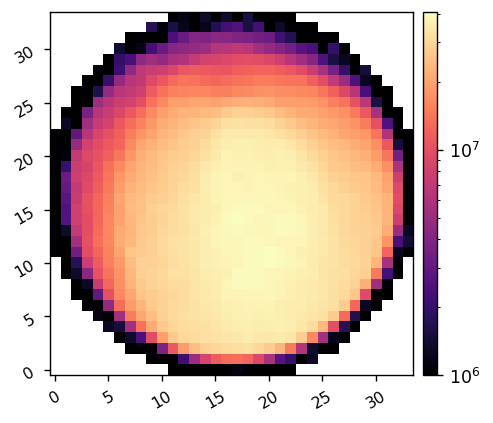

In [61]:
reload(lina.utils)
# response = lina.utils.map_acts_to_dm(xp.sqrt(((jac)**2).sum(axis=0)).get(), model.dm_mask)

responses = jac[::2] + 1j*jac[1::2]
dm_response = xp.sqrt(xp.mean(xp.abs(responses.dot(xp.array(calib_modes)))**2, axis=0)).reshape(model.Nact, model.Nact)
imshow1(dm_response, lognorm=True, vmin=1e6)

In [64]:
reload(lina.scc)
scc_params.update({'plot_est':True})

In [71]:
control_matrix = lina.utils.beta_reg(jac, -2)

In [68]:
model.reset_dm()

images = xp.array([ref_im])
efields = xp.array([E_est])
commands = xp.array([model.get_dm()])

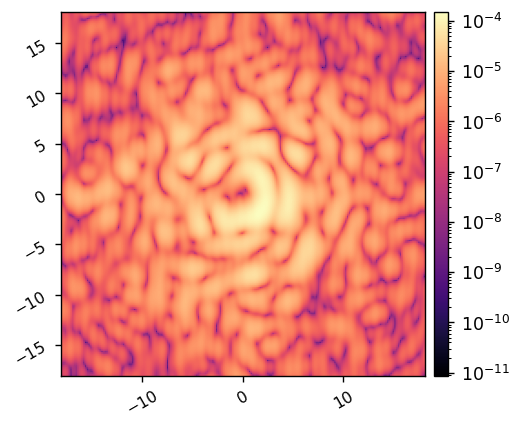

array([[1.05959101e-07, 1.63166856e-07, 1.77028873e-07, ...,
        1.71577673e-07, 4.29677553e-08, 1.06166318e-08],
       [1.34066175e-07, 1.93861856e-07, 2.07207494e-07, ...,
        2.22137494e-07, 7.33823506e-08, 4.10264433e-08],
       [1.41156066e-07, 1.97726865e-07, 2.10592309e-07, ...,
        2.78919886e-07, 1.21141955e-07, 9.15640631e-08],
       ...,
       [3.93709819e-07, 4.77044835e-07, 5.99892402e-07, ...,
        4.15563828e-07, 2.95411041e-07, 3.11296843e-07],
       [3.93540519e-07, 4.50316680e-07, 5.52315531e-07, ...,
        2.86252136e-07, 2.14134019e-07, 2.56221740e-07],
       [3.85044128e-07, 4.19159176e-07, 4.99627674e-07, ...,
        1.44187500e-07, 1.17800196e-07, 1.74462951e-07]])

In [69]:
model.snap(plot=True)

Beginning closed-loop EFC.
	Running iteration 1/5.
Using model to compute electric field


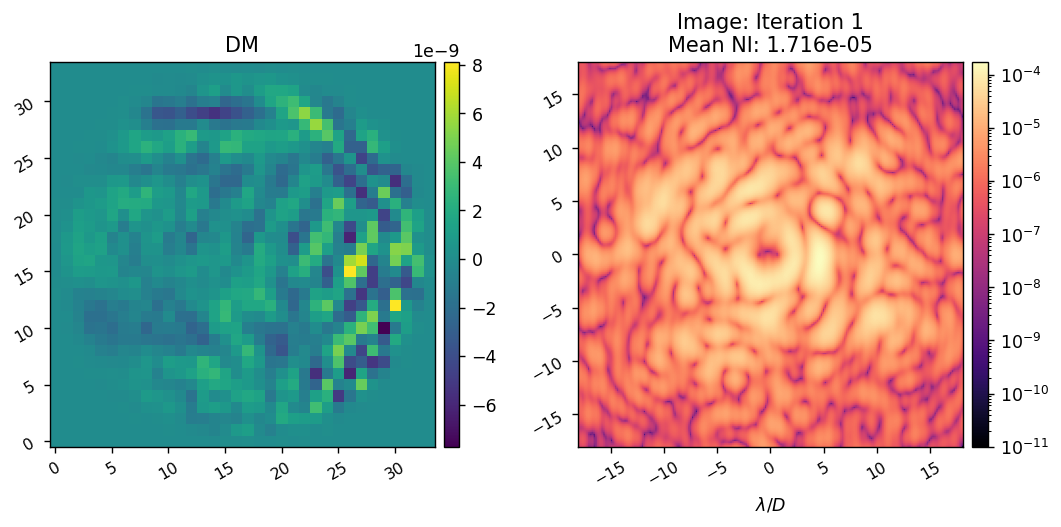

	Running iteration 2/5.
Using model to compute electric field


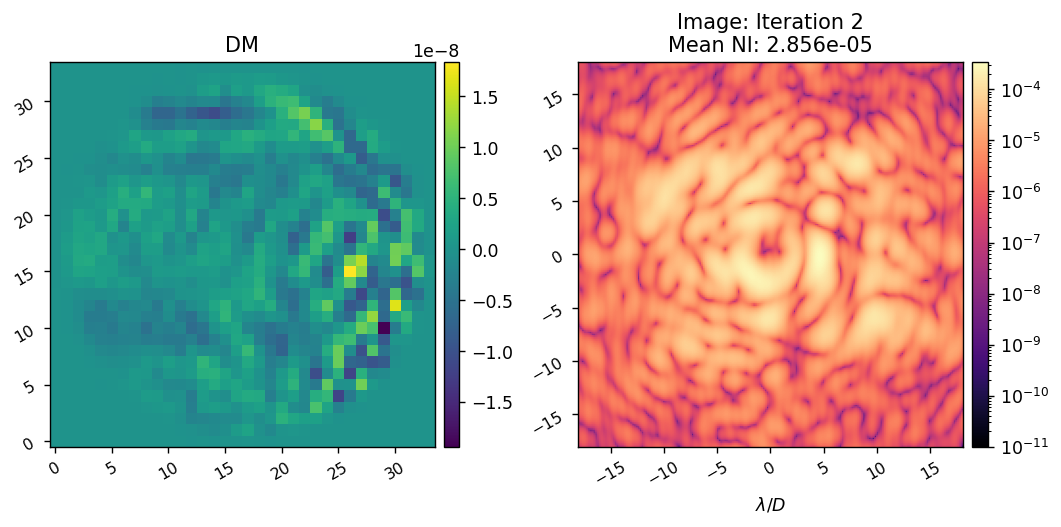

	Running iteration 3/5.
Using model to compute electric field


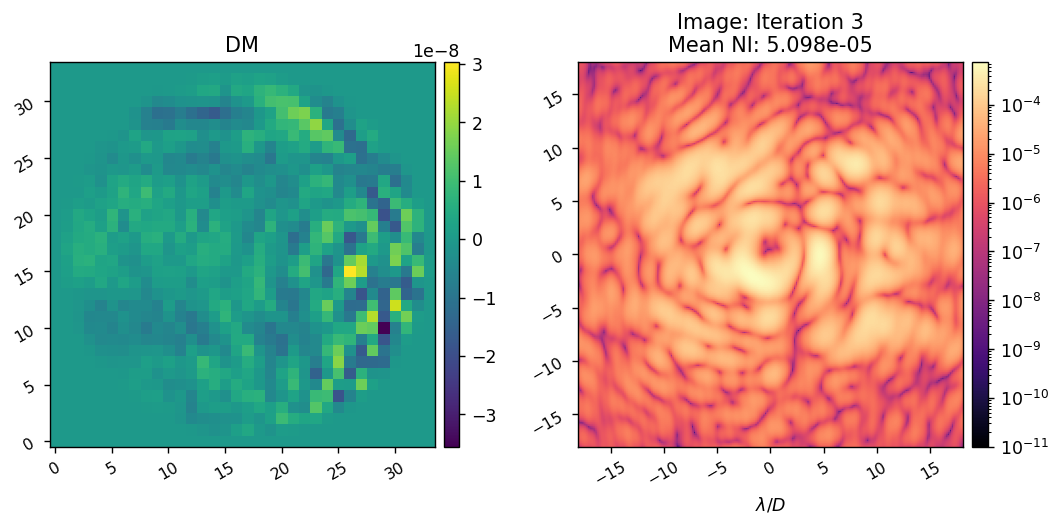

	Running iteration 4/5.
Using model to compute electric field


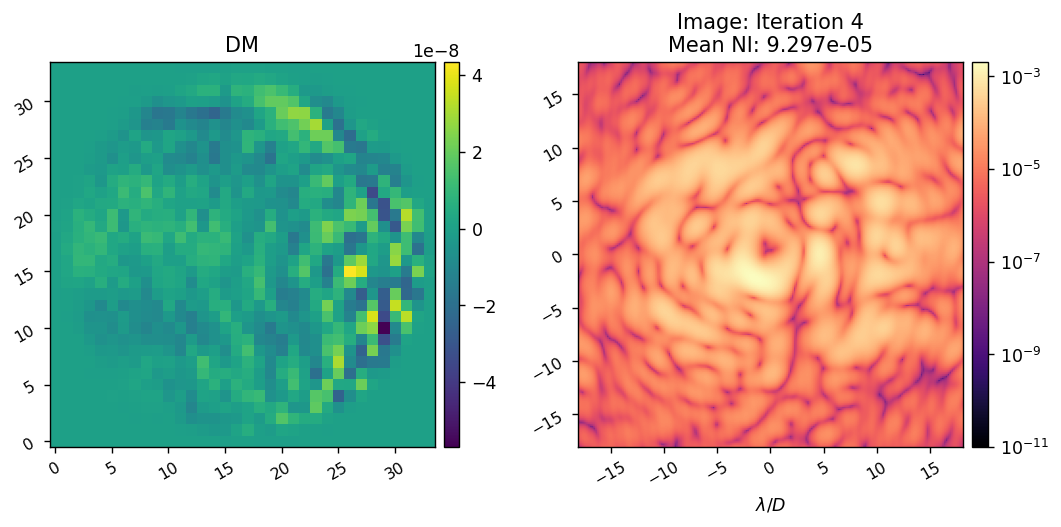

	Running iteration 5/5.
Using model to compute electric field


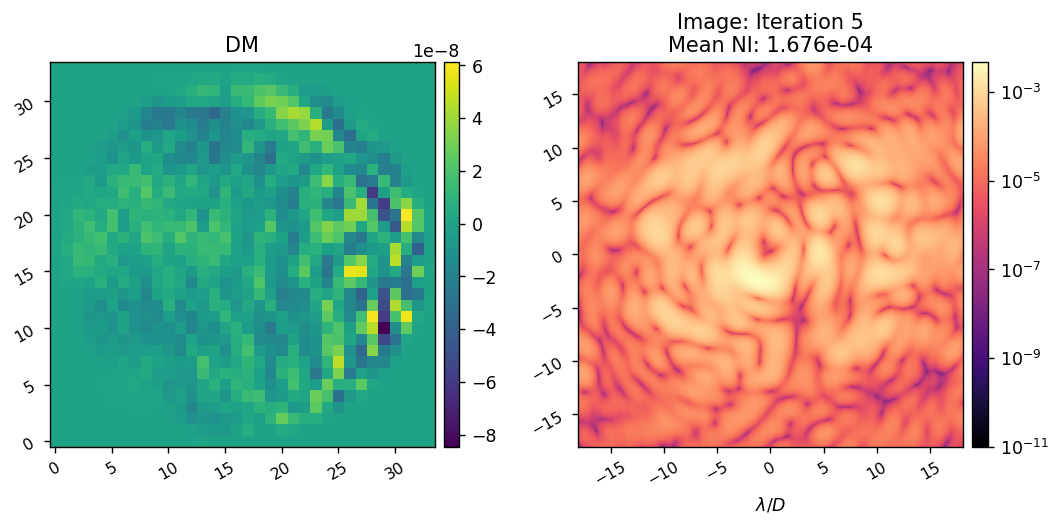

EFC completed in 8.473 sec.


In [72]:
reload(lina.efc)

images, efields, commands = lina.efc.run(model, 
                                         calib_modes,
                                        control_matrix,
                                        control_mask, 
                                        # est_fun=scc_fun,
                                        # est_params=scc_params,
                                        loop_gain=0.5, 
                                        leakage=0.0,
                                        iterations=5, 
                                        plot_all=True, 
                                        plot_radial_contrast=False,
                                        old_images=images,
                                        old_fields=efields,
                                        old_commands=commands,)